In [130]:
import pandas as pd 
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 
%matplotlib inline

import pandas as pd 
import numpy as np 
# Display all columns 
pd.options.display.max_columns = None
import datetime
from datetime import datetime 
from datetime import date, timedelta

import datetime
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import seaborn as sns 
import pickle 

#### Helper Function: 

In [2]:
def model_mat(y_test,y_pred):
    acc = metrics.accuracy_score(y_test,y_pred)
    prec = metrics.precision_score(y_test,y_pred)
    recall = metrics.recall_score(y_test,y_pred)
    fscore=metrics.f1_score(y_test,y_pred)
    
    mdf = pd.DataFrame({'Scores':[acc,prec,recall,fscore]},index=['Accuracy','Precision','Recall','F1-Score']).T
    return mdf 


def costamized_metric(y_test,y_pred, **kwargs):
    
    my_metric = kwargs['my_metric']
    
    M= metrics.confusion_matrix(y_test,y_pred)
    TP = M[1,1]
    TN = M[0,0]
    FP = M[0,1]
    FN = M[1,0]
    
    metric_dic = dict()
    metric_dic['SEN'] = TP/(TP+FN)  # Sensitivity
    metric_dic['SPC'] = TN/(TN+FP)  # Specificity
    metric_dic['PPV'] = TP/(TP+FP)  # Positive Predictive Value
    metric_dic['NPV'] = TN/(TN+FN)  # Negative Predictive Value
    metric_dic['ACCURACY'] = (TP+TN)/((TP+TN+FP+FN))
    
    if my_metric not in ['SEN','SPC','PPV','NPV', 'ACCURACY','ALL']:
        print('-------'*10)
        print('Wrong metric asked')
    
    elif my_metric == 'ALL':
        scores = pd.DataFrame()
        scores['Metric'] = [I[0] for I in metric_dic.items()]
        scores['Value']  = [I[1] for I in metric_dic.items()]
  
    else:
        scores = metric_dic[my_metric]
        
    return np.round(scores,4)

def plot_AUC_roc_curve_(y_test, y_pred, classifier, model_name):
    ns_probs = [0 for _  in range(len(y_test))]
    y_pred_prob = classifier.predict_proba(X_test)
    y_pred_prob = y_pred_prob[:,1]
    ns_auc = metrics.roc_auc_score(y_test,ns_probs)

    ns_fpr,ns_tpr, _ = metrics.roc_curve(y_test,ns_probs)
    classifier_fpr,classifier_tpr, _ = metrics.roc_curve(y_test,y_pred_prob)

    nb_roc_auc = metrics.roc_auc_score(y_test,y_pred)

    plt.plot(ns_fpr,ns_tpr,linestyle = '--',color='red')
    plt.plot(classifier_fpr,classifier_tpr,marker='o',color='orange',label= model_name + ' (area = %0.3f)' % nb_roc_auc)
    plt.ylabel('True Positive Rate',size=14)
    plt.xlabel('False Positive Rate',size=14)
    plt.title(model_name + ' AUC-ROC curve',size=18)
    plt.rcParams['axes.spines.right']=True # remove the plot border
    plt.rcParams['axes.spines.left']=True # remove the plot border
    plt.rcParams['axes.spines.top']=True # remove the plot border
    plt.rcParams['axes.spines.bottom']=True #
    plt.legend() 
    plt.show()
    

    
    
def labeled_barplot(data,feature,perc=False,n=None):
    """
    Plot barplot with percentage at the top
    data: provide any dataframe df
    perc: dataframe column percentage
    n: displays the top n category levels (default is None, i.e. display all level)
    """
    total = len(data[feature]) # length of all items in the column
    count = data[feature].nunique() # get the unique values in that particular columns
    
    if n is None:
        plt.figure(figsize=(count+1,5))
        #print(plt.figure(figsize=(count+1,5)))
    else:
        plt.figure(figsize=(n+1,5))
    
    plt.xticks(rotation=90,fontsize=14) # make x ticks vertical and give it fontsize 14
    ax = sns.countplot(
        data=data,
        y=feature,
        #palette="flare", # other pallete https://seaborn.pydata.org/generated/seaborn.color_palette.html
        order=data[feature].value_counts().index[:n]) # makes the bar sorted by its count value
    
    for p in ax.patches:
        #print(p)
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot
        #print('x is: ',x)
        #print('y is: ',y)

# https://www.geeksforgeeks.org/matplotlib-pyplot-annotate-in-python/
        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=15,
            xytext=(0, 5), # makes text on the bar to align to the center 
            textcoords="offset points",
        ) 
            

In [3]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.shape

(5110, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


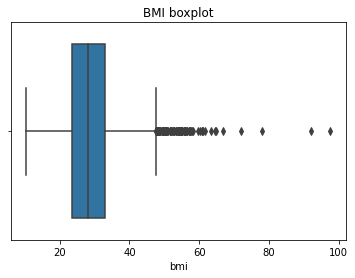

In [6]:
sns.boxplot(df['bmi'])
plt.title('BMI boxplot')
plt.show()

In [7]:
# Impute 
# Feature bmi has some outlier. So use median 
imputer = SimpleImputer(missing_values=np.nan,strategy='median')
df['bmi'] = imputer.fit_transform(df.loc[:,'age'].values.reshape(-1,1))
#df.loc[df['bmi'].isin([np.nan]),'bmi'] = df['bmi'].median()

In [8]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,67.0,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,61.0,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,80.0,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,49.0,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,79.0,never smoked,1


In [9]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,43.226614,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,22.612647,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,0.080000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,25.000000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,45.000000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,61.000000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,82.000000,1.000000


In [10]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [11]:
df['gender'] = df['gender'].map({'Female':0,'Male':1,'Other':0})
df['ever_married'] = df['ever_married'].map({'Yes':1,'No':0})

In [185]:
df.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,Private,Urban,228.69,67.0,formerly smoked,1
1,0,61.0,0,0,1,Self-employed,Rural,202.21,61.0,never smoked,1


In [186]:
df['ever_married'].value_counts()

1    3353
0    1757
Name: ever_married, dtype: int64

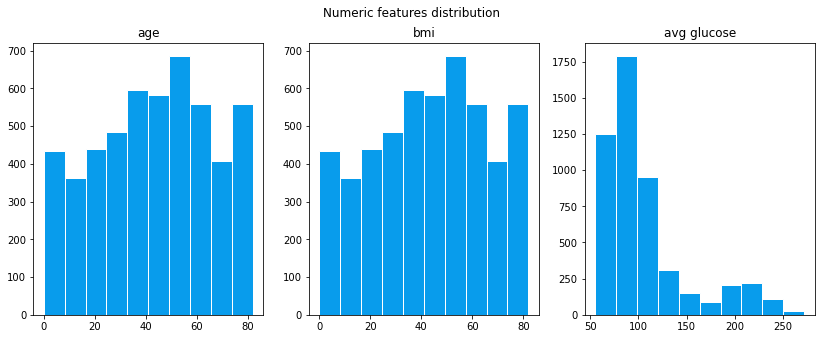

In [187]:
fig,ax = plt.subplots(1,3,figsize=(14,5))
ax[0].hist(df['age'],color='#089CEC',edgecolor='white')
ax[0].set(title='age')
ax[1].hist(df['bmi'],color='#089CEC',edgecolor='white')
ax[1].set(title='bmi')
ax[2].hist(df['avg_glucose_level'],color='#089CEC',edgecolor='white')
ax[2].set(title='avg glucose')
plt.suptitle('Numeric features distribution')
plt.show()

In [188]:
df['age'].describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

In [189]:
df[df['age']<=10].head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,0,1.32,0,0,0,children,Urban,70.37,1.32,Unknown,1
249,1,3.00,0,0,0,children,Rural,95.12,3.00,Unknown,0
251,0,8.00,0,0,0,Private,Urban,110.89,8.00,Unknown,0


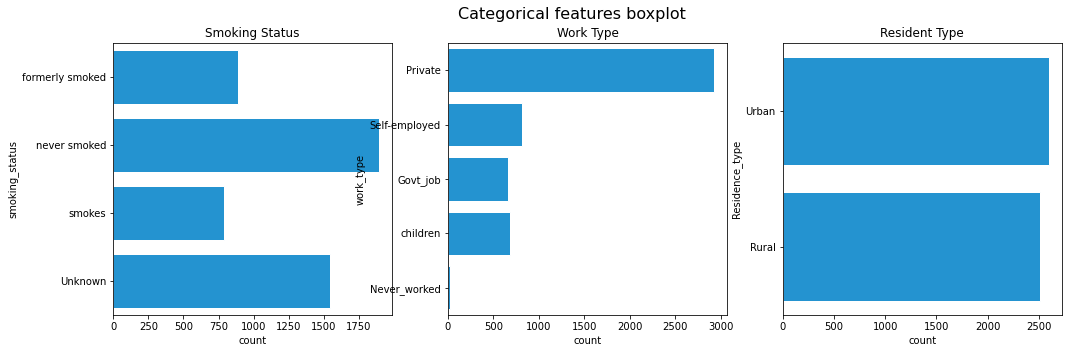

In [190]:
fig,ax = plt.subplots(1,3,figsize=(17,5))
sns.countplot(y=df['smoking_status'],color='#089CEC',edgecolor='white',ax=ax[0])
ax[0].set(title='Smoking Status')
sns.countplot(y=df['work_type'],color='#089CEC',edgecolor='white',ax=ax[1])
ax[1].set(title='Work Type')
sns.countplot(y=df['Residence_type'],color='#089CEC',edgecolor='white',ax=ax[2])
ax[2].set(title='Resident Type')
plt.suptitle('Categorical features boxplot',size=16)
plt.show()


#### Feature Engineering:  

In [192]:
df = df.drop(columns='id')

In [193]:
cat_features = [col for col in df.select_dtypes(include='object')]
print('Categorical Features:')
cat_features

Categorical Features:


['work_type', 'Residence_type', 'smoking_status']

In [194]:
continue_feat = [col for col in df.select_dtypes(include='float64')]
continue_feat

['age', 'avg_glucose_level', 'bmi']

In [195]:
num_features = [col for col in df.select_dtypes(include='int64')]
print('Numeric features:')
num_features

Numeric features:


['gender', 'hypertension', 'heart_disease', 'ever_married', 'stroke']

In [196]:
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,Private,Urban,228.69,67.0,formerly smoked,1
1,0,61.0,0,0,1,Self-employed,Rural,202.21,61.0,never smoked,1
2,1,80.0,0,1,1,Private,Rural,105.92,80.0,never smoked,1


In [197]:
cat_feature = df[cat_features] 
cat_feature.head(3)


,work_type,Residence_type,smoking_status
0,Private,Urban,formerly smoked
1,Self-employed,Rural,never smoked
2,Private,Rural,never smoked


In [198]:
num_feature = df[num_features]
num_feature.head(3)

,gender,hypertension,heart_disease,ever_married,stroke
0,1,0,1,1,1
1,0,0,0,1,1
2,1,0,1,1,1


In [199]:
unscaled_features = df[continue_feat]
unscaled_features.head(3)

,age,avg_glucose_level,bmi
0,67.0,228.69,67.0
1,61.0,202.21,61.0
2,80.0,105.92,80.0


In [200]:
scaler = StandardScaler()
scaler.fit(unscaled_features.values)

StandardScaler()

In [201]:
scaled_features= scaler.transform(unscaled_features.values)
scaled_features 

array([[ 1.05143428,  2.70637544,  1.05143428],
       [ 0.78607007,  2.12155854,  0.78607007],
       [ 1.62639008, -0.0050283 ,  1.62639008],
       ...,
       [-0.36384151, -0.51144264, -0.36384151],
       [ 0.34379639,  1.32825706,  0.34379639],
       [ 0.03420481, -0.46086746,  0.03420481]])

In [202]:
scaled_features = pd.DataFrame(scaled_features,index=unscaled_features.index,columns=unscaled_features.columns)
scaled_features.head(3)

,age,avg_glucose_level,bmi
0,1.051434,2.706375,1.051434
1,0.786070,2.121559,0.786070
2,1.626390,-0.005028,1.626390


In [29]:
#dum_featurs = pd.get_dummies(cat_feature,prefix=)

In [203]:
for col in cat_feature:
    dum_features = pd.get_dummies(cat_feature)
    df_clean_sc = pd.concat([unscaled_features,num_feature,dum_features],axis=1) # change to scaled for feature imp

In [204]:
df_clean_sc.head(3)

,age,avg_glucose_level,bmi,gender,hypertension,heart_disease,ever_married,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,228.69,67.0,1,0,1,1,1,0,0,1,0,0,0,1,0,1,0,0
1,61.0,202.21,61.0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0
2,80.0,105.92,80.0,1,0,1,1,1,0,0,1,0,0,1,0,0,0,1,0


0    4861
1     249
Name: stroke, dtype: int64


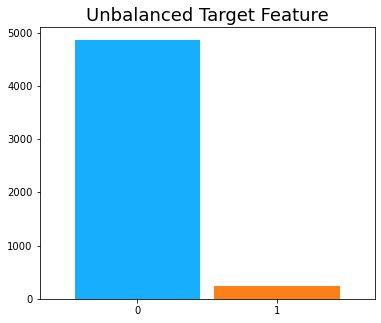

In [205]:
print(df_clean_sc['stroke'].value_counts())
df_clean_sc['stroke'].value_counts().plot(kind='bar',width=0.9,rot='horizontal',figsize=(6,5),color=['#17AFFD','#FD7F17']) 
plt.title('Unbalanced Target Feature',size=18)
plt.show()


In [206]:
#X = df_clean.drop(['stroke'],axis=1)
#y = df_clean['stroke']

X = df_clean_sc.drop(['stroke'], axis = 1)
y = df_clean_sc['stroke']

In [396]:
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123,stratify=y)
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)
#from sklearn.model_selection import train_test_split as tts

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100,stratify=y) 

print('Train Shape: ', X_train.shape)
print('Test Shape: ', X_test.shape)

Train Shape:  (3577, 18)
Test Shape:  (1533, 18)


## Feature Importance: 

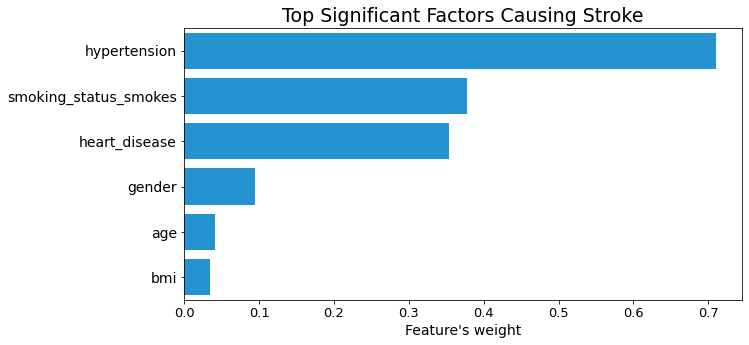

In [208]:
lr_l_one_cv = LogisticRegression(penalty='l1',
                             class_weight='balanced',
                             solver='liblinear',
                             max_iter=500,
                                 random_state=123
                             )
lr_l_one_cv

lr_l_one_cv.fit(X_train,y_train)

lr_l_one_cv.score(X_train,y_train)

# Create pandas series of features weight and column names 
features_weights_pds = pd.Series(lr_l_one_cv.coef_[0],index=X.columns)
features_weights_pds=features_weights_pds.sort_values(ascending=False)
top_ten_features = features_weights_pds.head(6).reset_index()
top_ten_features = top_ten_features.rename(columns={'index':'features',0:'weights'})
top_ten_features

plt.figure(figsize=(10,5))
sns.barplot(y='features',x='weights',data=top_ten_features,color='#089CEC')
plt.title('Top Significant Factors Causing Stroke',size=19)
plt.ylabel(None)
plt.xlabel("Feature's weight",size=14)
plt.rcParams['axes.spines.right']=False # remove the plot border
plt.rcParams['axes.spines.left']=True # remove the plot border
plt.rcParams['axes.spines.top']=False # remove the plot border
plt.rcParams['axes.spines.bottom']=False # remove the plot border
plt.xticks(size=13)
plt.yticks(size=14)
plt.show()

In [209]:
lr_cv = LogisticRegressionCV(penalty='l2',
                             cv=3,
                             class_weight='balanced',
                             solver= 'liblinear')
lr_cv
lr_cv.fit(X_train,y_train)

LogisticRegressionCV(class_weight='balanced', cv=3, solver='liblinear')

In [34]:
X_test.head(2)

,age,avg_glucose_level,bmi,gender,hypertension,heart_disease,ever_married,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2119,42.0,68.24,42.0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0
482,78.0,73.32,78.0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0


In [210]:
y_pred = lr_cv.predict(X_test)

In [211]:
# Unscaled data 
metrics.confusion_matrix(y_test,y_pred)

array([[1110,  348],
       [  16,   59]])

In [212]:
# scaled data 
metrics.confusion_matrix(y_test,y_pred)

array([[1110,  348],
       [  16,   59]])

In [38]:
# Unscaled data
model_mat(y_test,y_pred)

,Accuracy,Precision,Recall,F1-Score
Scores,0.762557,0.144963,0.786667,0.244813


In [39]:
# Scaled Data 
model_mat(y_test,y_pred)

,Accuracy,Precision,Recall,F1-Score
Scores,0.762557,0.144963,0.786667,0.244813


In [41]:
1110/(1110+16)

0.9857904085257548

In [42]:
costamized_metric(y_test, y_pred,my_metric='ALL')

,Metric,Value
0,SEN,0.7867
1,SPC,0.7613
2,PPV,0.1450
3,NPV,0.9858
4,ACCURACY,0.7626


In [43]:
lr = LogisticRegression(penalty='l2',
                        class_weight='balanced',
                        C=0.1,
                       solver='liblinear')
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

In [44]:
# Unscaled 
model_mat(y_test,y_pred_lr)

,Accuracy,Precision,Recall,F1-Score
Scores,0.757339,0.142169,0.786667,0.240816


In [45]:
model_mat(y_test,y_pred_lr)

,Accuracy,Precision,Recall,F1-Score
Scores,0.757339,0.142169,0.786667,0.240816


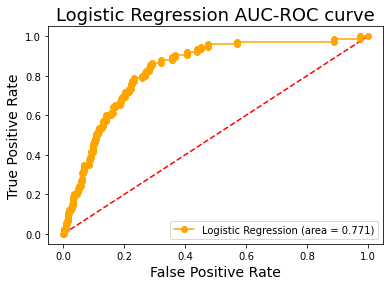

In [46]:
plot_AUC_roc_curve_(y_test,y_pred_lr,lr,'Logistic Regression')

## Random Forest: 

In [213]:
tunned_paramters = {
    'n_estimators':[10,50,100,300,500],
    'criterion': ['gini','entropy'],
    'max_depth':[5,8,10,15,20],
    'min_samples_split':[2,4,8],
    'class_weight':['balanced','balanced_subsample']
}
rf = RandomForestClassifier()

In [214]:
# Scaled 
%%time
rs_clf = RandomizedSearchCV(estimator=rf,param_distributions=tunned_paramters,scoring='roc_auc',n_jobs=-1)
rs_clf.fit(X_train,y_train)
print('Best paramters for RF model are: ')
print(rs_clf.best_params_)

UsageError: Line magic function `%%time` not found.


In [382]:
# Unscaled 
rs_clf = RandomizedSearchCV(estimator=rf,param_distributions=tunned_paramters,scoring='accuracy',n_jobs=-1)
rs_clf.fit(X_train,y_train)
print('Best paramters for RF model are: ')
print(rs_clf.best_params_)

Best paramters for RF model are: 
{'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 15, 'criterion': 'gini', 'class_weight': 'balanced'}


In [64]:
for mean,std,params in zip(rs_clf.cv_results_['mean_test_score'],rs_clf.cv_results_['std_test_score'],rs_clf.cv_results_['params']):
    print('accuracy is: %2f std: (+/-%0.2f) for parameters: % r'%(mean,std,params))

accuracy is: 0.943528 std: (+/-0.00) for parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 20, 'criterion': 'gini', 'class_weight': 'balanced'}
accuracy is: 0.912214 std: (+/-0.01) for parameters: {'n_estimators': 300, 'min_samples_split': 8, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}
accuracy is: 0.759567 std: (+/-0.02) for parameters: {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}
accuracy is: 0.941571 std: (+/-0.01) for parameters: {'n_estimators': 50, 'min_samples_split': 4, 'max_depth': 15, 'criterion': 'entropy', 'class_weight': 'balanced'}
accuracy is: 0.946045 std: (+/-0.00) for parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 15, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}
accuracy is: 0.746428 std: (+/-0.02) for parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 5, 'criterion': 'entropy', 

In [142]:
# Scaled data 
rf_tunned = RandomForestClassifier(n_estimators=100,
                                   class_weight='balanced',
                                   criterion='gini',
                                   max_depth=5,
                                   random_state=123,
                                   min_samples_split=2)
rf_tunned.fit(X_train,y_train)
y_pred_rf = rf_tunned.predict(X_test)

In [182]:
# Unsaled tunned parameters (tunned based on accuracy)
rf_tunned = RandomForestClassifier(n_estimators=100,
                                   class_weight='balanced',
                                   criterion='gini',
                                   max_depth=5,
                                   random_state=123,
                                   min_samples_split=10)
rf_tunned.fit(X_train,y_train)
y_pred_rf = rf_tunned.predict(X_test)

In [183]:
model_mat(y_test,y_pred_rf)

,Accuracy,Precision,Recall,F1-Score
Scores,0.756686,0.145238,0.813333,0.246465


***Recall:***  Out of all the people who really have store, what percent of those pelple did our model say will have stroke. 

***Precision:**** Out of the people that our model said would have stroke, what percent of those people have stroke. 


In [148]:
metrics.confusion_matrix(y_test,y_pred_rf)

array([[1323,  135],
       [  45,   30]])

In [149]:
y_pred_prob_rf = rf_tunned.predict_proba(X_test)
y_pred_prob_rf

array([[0.88293606, 0.11706394],
       [0.54793441, 0.45206559],
       [0.98289752, 0.01710248],
       ...,
       [1.        , 0.        ],
       [0.79589383, 0.20410617],
       [0.96738201, 0.03261799]])

In [159]:
y_pred_prob_rf[:,1] # get only the prob of 1s 

array([0.11706394, 0.45206559, 0.01710248, ..., 0.        , 0.20410617,
       0.03261799])

In [152]:
y_pred_rf

array([0, 0, 0, ..., 0, 0, 0])

## Create dataset with prediction and probabilities 

In [150]:
X_test.head()

,age,avg_glucose_level,bmi,gender,hypertension,heart_disease,ever_married,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2119,42.0,68.24,42.0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0
482,78.0,73.32,78.0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0
464,25.0,95.59,25.0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
4900,7.0,77.12,7.0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0
1321,30.0,82.56,30.0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0


In [151]:
prediction  = X_test.copy()

In [154]:
prediction['prediction'] = y_pred_rf

In [160]:
prediction['probabilities'] = y_pred_prob_rf[:,1]

In [162]:
prediction.tail()

,age,avg_glucose_level,bmi,gender,hypertension,heart_disease,ever_married,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,prediction,probabilities
1897,19.00,131.23,19.00,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.000000
997,55.00,56.42,55.00,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0.252994
2116,1.24,109.97,1.24,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0.000000
3049,52.00,110.36,52.00,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.204106
2367,35.00,83.27,35.00,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0.032618


In [165]:
prediction.to_csv('stroke_prediction.csv')

In [164]:
# Scaled Tunned 
model_mat(y_test,y_pred_rf)

,Accuracy,Precision,Recall,F1-Score
Scores,0.773646,0.151282,0.786667,0.253763


In [165]:
costamized_metric(y_test, y_pred_rf,my_metric='ALL')

,Metric,Value
0,SEN,0.7867
1,SPC,0.7730
2,PPV,0.1513
3,NPV,0.9860
4,ACCURACY,0.7736


In [50]:
metrics.roc_auc_score(y_test,y_pred_rf)

0.5099039780521262

In [51]:
metrics.confusion_matrix(y_test,y_pred_rf)

array([[1448,   10],
       [  73,    2]])

In [168]:
from sklearn.model_selection import cross_val_score

In [169]:
cross_val_score(rf_tunned,X_train,y_train,cv=5,scoring='accuracy')

array([0.79888268, 0.74441341, 0.74685315, 0.75384615, 0.74265734])

In [171]:
cross_val_score(rf_tunned,X_train,y_train,cv=5,scoring='accuracy').mean()

0.7576098761573621

## Build model on only importance features: 

In [52]:
X_imp = df_clean_sc[['age','hypertension','bmi','smoking_status_smokes','heart_disease','avg_glucose_level']]
X_imp.head(2) 

,age,hypertension,bmi,smoking_status_smokes,heart_disease,avg_glucose_level
0,67.0,0,67.0,0,1,228.69
1,61.0,0,61.0,0,0,202.21


In [53]:
x_train_imp,x_test_imp,y_train,y_test  = train_test_split(X_imp,y,test_size=0.2,random_state=123)

In [54]:
x_test_imp.head(1)

,age,hypertension,bmi,smoking_status_smokes,heart_disease,avg_glucose_level
1708,14.0,0,14.0,0,0,57.95


In [123]:
rf_model = RandomForestClassifier(n_estimators=100,
                                   class_weight='balanced',
                                   criterion='gini',
                                   max_depth=8,
                                   random_state=123,
                                   min_samples_split=2)


rf_model.fit(x_train_imp,y_train) 

RandomForestClassifier(class_weight='balanced', max_depth=8, random_state=123)

In [124]:
y_pred_imp = rf_model.predict(x_test_imp)

In [ ]:
y_pred_imp

In [126]:
model_mat(y_test,y_pred_imp)

,Accuracy,Precision,Recall,F1-Score
Scores,0.829746,0.130952,0.44,0.201835


In [125]:
metrics.confusion_matrix(y_test,y_pred_imp)

array([[826, 146],
       [ 28,  22]])

***Recall:***  Out of all the people who really have store, what percent of those pelple did our model say will have stroke. 

***Precision:**** Out of the people that our model said would have stroke, what percent of those people have stroke. 



In [132]:
y_pred_imp

array([0, 0, 0, ..., 0, 0, 0])

In [101]:
20/(20+93)

0.17699115044247787

In [70]:
x_test_imp.iloc[239,:]

age                      81.00
hypertension              1.00
bmi                      81.00
smoking_status_smokes     0.00
heart_disease             1.00
avg_glucose_level        59.28
Name: 2497, dtype: float64

In [76]:
y_test.shape

(1022,)

In [77]:
y_pred_imp.shape

(1022,)

1708    0
4768    0
1972    0
981     0
2423    0
       ..
1121    0
4688    0
901     0
5104    0
3605    0
Name: stroke, Length: 1022, dtype: int64

In [127]:
tp = pd.DataFrame(y_test)
tp['pred'] = y_pred_imp

In [128]:
tp.T 

,1708,4768,1972,981,2423,2823,1155,2629,893,4866,1318,1818,2964,239,4463,1574,722,4542,1672,984,3967,4527,2926,5040,4301,2613,248,4953,3341,1564,738,2471,4351,3246,4684,1963,3354,4878,3191,1388,220,3887,4989,3376,2018,3240,3941,5054,4024,2752,2530,4802,2526,4921,4374,3820,527,785,1783,193,2290,2950,4770,3629,3682,2998,2883,1033,2347,3337,3947,1229,5059,1172,1074,4339,2432,3849,1660,843,803,4863,184,2742,3480,2450,927,528,1971,3022,116,770,4506,1071,835,2060,1909,288,1882,2891,3955,2769,3190,3672,1653,31,4695,2746,4269,889,1243,3147,77,1187,833,30,3851,2312,1462,2083,4345,4088,4771,119,4288,5053,4326,2767,3578,3554,3566,92,2246,2952,2064,3007,263,3562,2427,569,4279,4555,1811,3744,4250,4660,5077,900,2556,3477,3390,4764,658,426,1112,1651,2805,1607,3010,440,1868,3784,3670,3916,15,849,2911,4192,608,429,5004,621,2247,775,646,2792,2482,4529,3141,2723,4359,381,1913,352,1878,1440,476,2658,3311,5090,4371,1459,3632,2069,3521,4810,1989,920,2175,3127,4093,5100,723,5088,1940,4036,418,2872,3748,2862,4185,1798,2493,879,2644,2583,165,838,2093,5009,3662,112,1554,576,614,1995,4204,2368,3420,1186,3666,4587,2229,995,4127,1182,2555,1355,1379,2497,4594,3108,902,2415,2142,1993,332,1421,1555,4922,4969,3615,3179,506,1502,3960,5073,2481,1120,1364,1519,1758,935,5064,1637,1568,1420,3985,118,364,1412,1822,84,3388,611,2968,761,202,244,4694,3832,1366,155,3445,3904,4358,2617,3300,1549,4655,146,4117,841,5086,2457,3264,2120,1371,3616,3513,72,2504,2404,3631,4574,2015,3894,4041,4686,2314,2313,2484,463,777,701,4481,3567,3863,511,298,2978,4758,1991,207,4444,3471,1476,2510,2057,380,3975,2123,4084,3443,5042,825,4021,1250,552,495,4417,1280,1138,1126,2908,403,2468,1793,2514,1114,1565,537,3061,115,812,3018,1103,2438,43,1001,4708,3674,4644,152,4710,1962,2965,2775,3710,2652,4829,3412,2962,1980,2406,671,4322,3182,2988,1451,4119,328,3949,3369,3057,1024,379,1325,649,822,2898,415,3279,3888,2155,543,3146,681,3826,4443,918,4583,3063,4122,4471,3754,4949,4020,4569,3509,1817,923,3929,774,2676,517,4469,3320,1843,3274,1955,4534,4828,1127,1370,3227,2542,5033,4221,549,1975,477,1974,1831,1066,1213,5092,2154,1727,2197,4383,4162,2075,1206,4832,3893,558,2763,3431,2959,4478,4393,2870,3986,333,1810,2733,1317,3906,3383,5007,2128,4748,1144,4893,1102,925,3813,1545,4993,4110,655,1373,1896,3113,3411,1469,4808,1397,1945,439,4987,4598,3255,1578,3550,4312,2354,3617,2022,4428,1929,148,1719,4191,2119,2411,2273,2086,204,4216,3762,4300,2885,2851,1796,2628,1668,2906,2960,3667,4787,3778,3056,61,1681,1064,3446,4357,3268,1766,5062,360,2034,4675,2295,4888,1553,1424,4319,1017,4240,714,1665,3785,4168,574,606,1723,3677,4429,276,1952,4642,3071,694,1084,1244,279,3798,335,2340,4196,343,3842,990,3593,613,3170,973,3276,3253,4797,25,1775,1195,3501,3289,2589,1733,2487,2672,4535,704,4208,2717,3794,2815,3647,4994,3137,131,4740,1781,3378,3475,2895,198,2572,3801,3278,2030,2488,3254,5031,3504,4730,4615,3804,1747,3843,4799,222,797,2848,2183,2762,4018,4051,2731,3648,2371,385,4977,4965,4900,3357,79,2413,1707,1284,33,4533,4696,134,3498,4903,2525,2789,1161,3296,444,4700,5030,3269,3729,1588,2550,4167,1969,267,5097,1137,1123,3301,1179,4553,2725,2416,3098,3879,595,1762,3198,1409,2327,1915,602,3845,1473,4147,129,4189,2849,3386,2653,3607,2667,2829,4154,640,1091,2536,4244,3346,3745,1266,1643,2288,2755,4554,3858,5078,1428,1671,4026,4058,3117,1983,406,3011,2063,3083,4641,2451,2479,3730,748,4317,4128,2877,3919,2825,2516,4788,743,2082,4159,4954,3493,4258,577,3456,1014,547,3404,969,805,2465,3037,4197,626,4217,3361,3263,4146,1471,457,3824,2713,3175,2087,1600,2688,540,966,1458,4601,3903,3649,2244,1692,1479,2590,730,2319,3372,3450,689,11,159,696,2524,5075,596,2971,24,4948,4432,319,2186,2196,1848,2519,3152,1384,4151,3251,2426,700,913,5000,2673,1765,3697,1982,3935,4233,4397,4103,4672,3957,2735,1726,3159,1495,1321,3000,996,670,2659,2066,4670,1426,4448,3585,3231,3466,820,2095,4663,387,4750,4643,4025,556,4870,853,3683,5005,1432,2271,1308,530,2697,1065,3846,4545,2765,1846,1807,1025,3774,4424,578,3938,1673,4891,1667,5027,4059,4354,4673,304,3167,48

In [85]:
tp.value_counts()

stroke
0         972
1          50
dtype: int64

In [89]:
t=x_test_imp.iloc[193,:]
t 

age                       66.00
hypertension               0.00
bmi                       66.00
smoking_status_smokes      1.00
heart_disease              0.00
avg_glucose_level        202.05
Name: 2069, dtype: float64

In [63]:
rf_model.predict_proba(t)

array([[0.24456938, 0.75543062],
       [0.45609491, 0.54390509]])

##### Save model 


In [131]:
pickle.dump(rf_model, open('stroke_rf_model.pkl', 'wb'))

In [473]:
t= x_test_imp.iloc[4,:]
tn = np.array([t])
tn 

array([[13.  ,  0.  , 13.  ,  0.  ,  0.  , 99.49]])

In [474]:
rf_model.predict_proba(tn)

array([[1., 0.]])

In [462]:
df_clean_sc[df_clean_sc['stroke']==1]

,age,avg_glucose_level,bmi,gender,hypertension,heart_disease,ever_married,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,228.69,67.0,1,0,1,1,1,0,0,1,0,0,0,1,0,1,0,0
1,61.0,202.21,61.0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0
2,80.0,105.92,80.0,1,0,1,1,1,0,0,1,0,0,1,0,0,0,1,0
3,49.0,171.23,49.0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1
4,79.0,174.12,79.0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,57.0,84.96,57.0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0
245,14.0,57.93,14.0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0
246,75.0,78.80,75.0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0
247,71.0,87.80,71.0,1,1,0,1,1,0,0,0,1,0,1,0,1,0,0,0


In [246]:
# Now build model on all data 
rf_model_final = RandomForestClassifier(n_estimators=100,
                                   class_weight='balanced',
                                   criterion='gini',
                                   max_depth=5,
                                   random_state=123,
                                   min_samples_split=2)
rf_model_final.fit(X_imp,y)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=123)

In [275]:
x_test_imp.iloc[0:2,0:5]

,age,hypertension,bmi,smoking_status_smokes,heart_disease
1708,-1.292616,0,-1.292616,0,0
4768,-1.159934,0,-1.159934,0,0


In [280]:
rf_model_final.predict_proba(x_test_imp.iloc[0:2,0:5])

array([[0.95000672, 0.04999328],
       [0.9940018 , 0.0059982 ]])

In [307]:
x_train.head(2) 

,age,avg_glucose_level,bmi,gender,hypertension,heart_disease,ever_married,smoking_status_Govt_job,smoking_status_Never_worked,smoking_status_Private,smoking_status_Self-employed,smoking_status_children,smoking_status_Rural,smoking_status_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2850,0.299569,-0.450046,0.299569,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
1617,1.184116,-0.887112,1.184116,1,1,0,1,0,0,1,0,0,0,1,0,1,0,0


In [332]:
t  = [13,0,15,0,0]
ta = np.array([t])
ta 

array([[13,  0, 15,  0,  0]])

In [333]:
predic = rf_model.predict_proba(ta)
predic

array([[0.25644566, 0.74355434]])

In [287]:
predic = lr.predict_proba(X_test.iloc[0:2,0:20])
predic

array([[0.78511058, 0.21488942],
       [0.17480807, 0.82519193]])

In [291]:
output='{0:.{1}f}'.format(predic[0][1], 2)
output

'0.21'

In [294]:
predic[0][1]

0.21488942416755927

## Save RF model as pickle file for  deployment

In [250]:
pickle.dump(rf_model, open('rf_model_final.pkl', 'wb'))

In [252]:
x_test_imp.head()

,age,hypertension,bmi,smoking_status_smokes,heart_disease
1708,-1.292616,0,-1.292616,0,0
4768,-1.159934,0,-1.159934,0,0
1972,-0.186932,0,-0.186932,0,0
981,0.122660,0,0.122660,0,0
2423,-1.336844,0,-1.336844,0,0


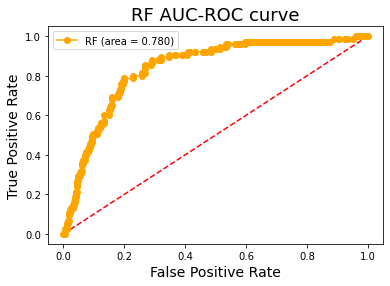

In [170]:
plot_AUC_roc_curve_(y_test,y_pred_rf,rf_tunned,'RF')

## Neural Network Model: 

In [ ]:
X_train_nn, y_train_nn, X_valid_nn, y_valid_nn, X_test_nn, y_test_nn = train_valid_test_split(X, target = 'y', 
                                                        train_size=0.7, valid_size=0.2, test_size=0.1, random_state=1234)

In [142]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping

In [143]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)

x_train,x_val,y_train2,y_val = train_test_split(X_train,y_train,test_size=0.2)

In [133]:
input_features = X.values.shape[1]
input_features

18

In [134]:
model = Sequential()
#model.add(Dense(10,input_dim = input_features,activation='relu'))
#model.add(Dense(30,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer = 'adam',metrics=['accuracy'])


In [135]:
safty = EarlyStopping(monitor='val_loss',patience=1,verbose=0)

In [136]:
#print('Fit model on training data')
history = model.fit(X_train,y_train,batch_size=120,epochs=40,validation_data=(x_val,y_val),callbacks=[safty])

Epoch 1/40

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

35/35 [==============================] - 0s 3ms/step - loss: 1.0428 - accuracy: 0.3124 - val_loss: 0.9745 - val_accuracy: 0.3313
Epoch 2/40
35/35 [==============================] - 0s 1ms/step - loss: 0.9400 - accuracy: 0.3689 - val_loss: 0.8809 - val_accuracy: 0.4132
Epoch 3/40
35/35 [==============================] - 0s 1ms/step - loss: 0.8476 - accuracy: 0.4349 - val_loss: 0.7979 - val_accuracy: 0.4841
Epoch 4/40
35/35 [==============================] - 0s 1ms/step - loss: 0.7650 - accurac

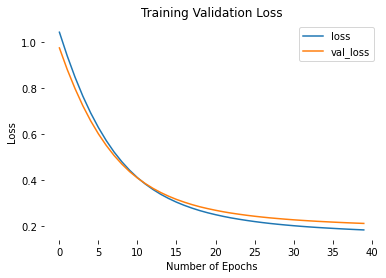

In [138]:
ax = pd.DataFrame(history.history).plot(y=['loss', 'val_loss'], title='Training Validation Loss')
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
plt.rcParams['axes.spines.right']=False # remove the plot border
plt.rcParams['axes.spines.left']=False # remove the plot border
plt.rcParams['axes.spines.top']=False # remove the plot border
plt.rcParams['axes.spines.bottom']=False #

In [139]:
Y_pred_prob_test = model.predict(X_test)

In [140]:
y_pred_class = model.predict_classes(X_test)

In [141]:
conf_mat = metrics.confusion_matrix(y_test,y_pred_class)
conf_mat

array([[972,   0],
       [ 50,   0]])

# Xgboost Classifier: 

In [109]:
#Xgboost
import xgboost as xgb 

In [93]:
%%time 
tunned_parameters = {
    
    'max_depth': [10,50,100],
    'n_estimators':[50,200,400],
    #'num_class':2,
    'eta':[0.06,0.5,1]
}

grid_search = GridSearchCV(xgb.XGBClassifier(),tunned_parameters,n_jobs=-1,cv=3) 


CPU times: user 59 µs, sys: 2 µs, total: 61 µs
Wall time: 63.9 µs


In [1]:
#xgb_clfs = xgb.XGBClassifier(eta=0.5,max_depth=10,n_estimator=200)

In [ ]:
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)
evallist = [(dtest,'eval'), (dtrain,'train')]

In [251]:
pwd 

'/Users/ghimirek/Desktop/Stroke_prediction'